# Empirical Mode Decomposition Analysis

In [1]:
import gsod
import numpy as np
# Using https://bitbucket.org/luukko/libeemd.git
# and its Python binding https://bitbucket.org/luukko/pyeemd.git
import pyeemd as eemd
from matplotlib import pyplot as plt
from numpy.fft import rfft

gsod.enable_svg_graphing()

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")["TEMP"]
indices = filled.index
d = np.asarray(filled)
filled

1933-01-01    56.6
1933-01-02    57.0
1933-01-03    51.5
1933-01-04    58.9
1933-01-05    64.6
              ... 
2021-08-27    85.5
2021-08-28    86.2
2021-08-29    84.0
2021-08-30    83.7
2021-08-31    74.4
Freq: D, Name: TEMP, Length: 32385, dtype: float64

In [3]:
imfs = eemd.ceemdan(d)

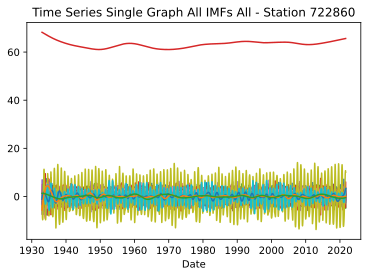

In [4]:
plt.title(f"Time Series Single Graph All IMFs All - Station {STATION}")
plt.xlabel("Date")
_ = plt.plot(indices, imfs.T)

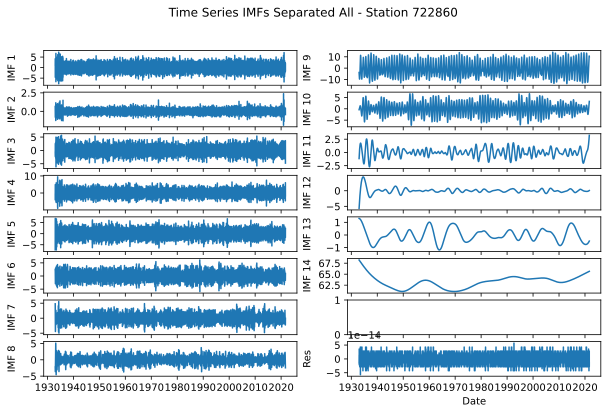

In [5]:
fig, ax = plt.subplots(int(np.ceil((len(imfs) + 1)/2)), 2, sharex=True)
ax = ax.T.flatten()
plt.gcf().set_size_inches(10, 6)
plt.xlabel("Date")
fig.suptitle(f"Time Series IMFs Separated All - Station {STATION}")

# Plot IMFs
for n, imf in enumerate(imfs):
    ax[n].set_ylabel(f"IMF {n + 1}")
    ax[n].plot(indices, imf)

# Residual
residual = sum(imfs) - d
    
ax[-1].set_ylabel("Res")
ax[-1].plot(indices, residual)
fig.align_labels()

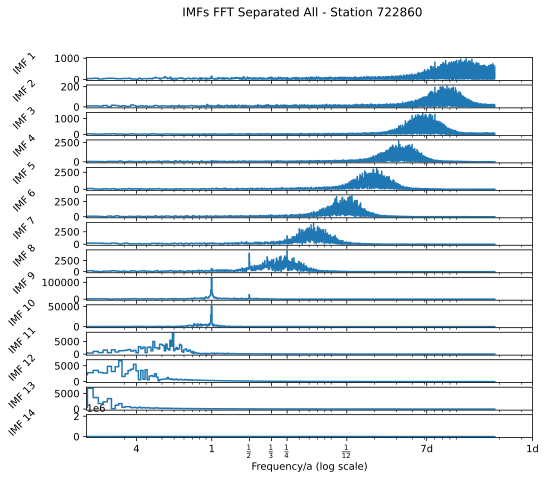

In [6]:
fig, ax = plt.subplots(len(imfs), 1, sharex=True)
n_samples_d = len(d)
days_per_year = 365.2524
years_per_dataset = n_samples_d/days_per_year
plt.gcf().set_size_inches(8, 7)
plt.xscale("log")
plt.xticks(
    [1/11, 1/4, 1, 2, 3, 4, 12, days_per_year/7, days_per_year],
    labels=["11", "4", "1", "$\\frac{1}{2}$", "$\\frac{1}{3}$", "$\\frac{1}{4}$", "$\\frac{1}{12}$", "7d", "1d"]
)
plt.xlim([0.1, max(plt.xlim())])
plt.xlabel("Frequency/a (log scale)")
fig.suptitle(f"IMFs FFT Separated All - Station {STATION}")

for n, imf in enumerate(imfs):
    fft = rfft(imf)
    f_per_dataset = np.arange(len(fft))
    f_per_year = f_per_dataset/years_per_dataset
    ax[n].step(f_per_year, np.abs(fft))
    ax[n].set_ylabel(f"IMF {n + 1}", rotation=45, loc="top")
fig.align_labels()

## Residual Analysis

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lbt

residual2 = residual
# Number of additional decompositions
nexcess = 10
fig, ax = plt.subplots(nexcess, 2)
plt.gcf().set_size_inches(8, 6)

fig.suptitle(f"IMFs Residual EMD Single and Ljung-Box P-Values Separated All - Station {STATION}")
ax[-1][0].set_xlabel("Date")
ax[-1][1].set_xlabel("Lag")
for ni in range(nexcess):
    ljungboxes = lbt(residual2, lags=np.arange(100), return_df=True)
    newp = eemd.emd(residual2)
    residual2 = residual2 - sum(newp)
    ax[ni][0].plot(indices, newp.T)
    ax[ni][1].plot(ljungboxes["lb_pvalue"])

## Save
Save decomposed temperatures for following procedures.

In [8]:
np.save("runtime/imfs.npy", imfs)